<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png"></a>

# Test comparing the original OverlandFlow Landlab component to our updated version of OverlandFlow
This notebook was created by Sam Anderson, Mikey Sison and Angel Monsalve.

<hr>
<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

** What is this notebook? **

THIS WILL BE CHANGED/EXPANDED UPON BY SAM USING FUTURE DRAFTS OF ANGEL'S PAPER. ALSO WILL HAVE MORE DETAILED INFO ABOUT THE FIGURES WHICH ARE GENERATED.
CONSIDER NAMING WHAT CAN BE CHANGED FOR THE CODE TO WORK, WHICH CANNOT, AND WHAT OTHER USERS WILL NEED IF THEY ARE TO USE THIS COMPONENT. I THINK THIS WILL HELP
FUTURE USERS, AND CAN BE APPLIED TO ALL 4 EXAMPLES, AND TO THE EXAMPLE THAT WE ARE MAKING IN LAST CHANCE CANYON.


This notebook generates results to compare the behaivor of the overland flow model presented by Adams et al. (2017) to the updated version used here to eventually couple with a sediment transport component. 

Our version of OverlandFlow was tested using the analytical solution for wave propagation on a flat surface case as first presented by Adams et al. (2017) and originally developed by Bates et al. (2010) and Hunter et al. (2005).
The idea of this test is to check if our version behaves in the same manner thand as the original OverlandFlow does under unsteady flow conditions. Our simulations were conducted in a flat domain of 6000 m long (x direction) 
and 800 m high (y direction) in which we used three different uniform grid configurations (∆x=∆y) with spacings of ∆x=5, 10, and 50 m. At the beginning of the simulation the domain was filled with a thin film of water of 1 mm. 
A uniform roughness coefficient was used (n=0.03). Boundary conditions at the top, right, and bottom edges of the domain were set to closed. Flow enters through the left edge (x=0 m) with a constant velocity of u=1 m/s and v=0 
m/s and water depth changes in time according to h(x,t)=h(0,t)=(7⁄3 n^2 u^3 t)^(3⁄7). 

After 3600 s of simulation we obtained identical results to those presented by Adams et al. (2017), indicating that our modifications to OverlandFlow do not affect the core of the flow solver (Figure 6). A detailed validation
is out of the scope our test and analysis but for more details on the validation the reader is referred to Adams et al. (2017).

More background on the model used here and the results presented will be published in the future and the citation will be added here:

**TITLE HERE PLEASE**

The code used in this exercise is taken from the above reference.



**Now on to the code.**
* Below we import Landlab components, functions for importing data, numpy and plotting tools. You should not need to change this.

In [1]:
## Code Block 1

%reset -f
import numpy as np
import copy
from matplotlib import pyplot as plt
from landlab.components import OverlandFlowSpatiallyVariableInputs
from landlab.io import read_esri_ascii
from landlab import imshow_grid



In the code block below, we define some important model parameters.

In [2]:
## Code Block 2

n = 0.03         # Manning's n
u = 1.0          # Constant velocity at the left edge flowing in the positive x direction - Boundary condition
dtPrecision = 3  # Avoids rounding errors
tPlot = 3600     # Plots will be obtained every amount of time in seconds specified here #VALUE CHANGED from Angel's code
storeData = 1200 # Stores results every amount of time in seconds specified here #VALUE CHANGED from Angel's code
tmax = 3600      # Maximum simulation time [s]
hMax = 3.0       # Maximum height of water (in meters) expected - This is used for plots only
h_init = 0.001   # Initial water depth in meters.


Now we import the data for the watershed we want to route flow on. This includes elevation data (DEM), and rasters containing roughness and rainfall intensity. THere are multiple DEM's we tested this on, and the user may change them, by changing the 'bedElevationDEM_dx5.asc' to 'bedElevationDEM_dx10.asc' or 'bedElevationDEM_dx50.asc'
Note that while in this example roughness and rainfall intensity are uniform, the updates we made to the OverlandFlow component allow for varying both of these fields.

In [3]:
## Code Block 3

bedElevationDEM = 'bedElevationDEM_dx5.asc'    # There are three DEM's the user can swap into this tutorial
(rmg, z) = read_esri_ascii(bedElevationDEM, name='topographic__elevation') 

rmg['link']['bed_surface__roughness'] = np.zeros(rmg.number_of_links) + n    # Roughness data
rmg['node']['rainfall_intensity'] = np.zeros(rmg.number_of_nodes)            # Rainfall intensity data


Here, we create some necessary topographic variables. You will need these if you use our updated overland flow component.

In [4]:
## Code Block 4

OverlandFlowSpatiallyVariableInputs.input_var_names  # This inputs necessary variable names
rmg.add_zeros('surface_water__depth', at = 'node')   # Creates all topographic, sediment, and flow variables

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

The code block below specifies boundry conditions. Here, all the boundries are "closed", you may consider changing boundry conditions if using our updated overland flow
component for your own research. See (https://notebook.community/landlab/landlab/notebooks/tutorials/boundary_conds/set_BCs_on_raster_perimeter) for background on boundry conditions.

In [5]:
## Code Block 6

# Sets boundaries to closed 
rmg.set_closed_boundaries_at_grid_edges(True,True,True,True)  

Code block 7 instantiates our updated overland flow component. Note that there are some variables which you can change if using this for your own research.

In [6]:
## Code Block 7

# Instantiation according to Adams et al 2017
of = OverlandFlowSpatiallyVariableInputs(rmg, h_init = h_init, steep_slopes = False, theta = 1.0, alpha = 0.7, dt_max = 7.5)

The following code is used for plotting purposes. It specifies, first, a node, and second, a link, to sample from. 

In [7]:
## Code Block 8

# ID for boundary nodes
# First we need to generate a list with the west-east nodes ID next to the left edge
# For a 120 columns raster these will be 121 241 361 etc..
nodesBoundary_Id = np.arange(rmg.number_of_node_columns,rmg.number_of_node_columns*(rmg.number_of_node_rows-1),(rmg.number_of_node_columns))

# ID for boundary links
# Now we need to generate a list with the west-east links ID at the left edge
# For a 120 column raster these will be 240 479 718 etc..
linksBoundary_Id = np.arange((2*rmg.number_of_node_columns)-1,rmg.number_of_links,(2*rmg.number_of_node_columns)-1)

The following code block defines variables needed to store data. This will come in handy when plotting changes over time. 

In [8]:
## Code Block 9

t = 0                                   # Initializates the variable
storeDataNow = True                     # Used to save the plot at time zero and again at tmax
plotNow = True                          # Used to save the plot at time zero and again at tmax
check_tmax = True
tPlotOrg=copy.deepcopy(tPlot)           # This makes a copy of tPlot
storeDataOrg=copy.deepcopy(storeData)   # This make a copy of storeData (go back to code block 3 and take a look at the description of the variable)

Here we run the code. This code block will take some time to run, so allow the code the time to do so before moving on. It will run up until tmax, which is defined in code block 3. The default run time is 3600 time steps (or seconds). NOTE: THE WATER DEPTH PLOT IS COMMENTED OUT, BECAUSE WE MAYBE DONT NEED IT?

In [9]:
## Code Block 10

while t <= tmax:
    
    h_boundary = np.max((0.001,(7/3 * n**2 * u**3 * t) ** (3/7)))
    q_boundary = u * h_boundary
    
    # Updates data in the grid
    rmg["node"]["surface_water__depth"][nodesBoundary_Id] = h_boundary
    rmg["link"]["surface_water__depth"][linksBoundary_Id] = h_boundary
    rmg["link"]["surface_water__discharge"][linksBoundary_Id] = q_boundary
    of.overland_flow()  # Runs overland flow for one time step
    
    ## Stores results
    storeData = round(storeData-of.dt, dtPrecision)
    if (storeData <= 0) or storeDataNow:
        print('Storing results at time :',np.round(t,1),' s')      
        data = np.reshape(np.hstack([t,(of._h.T)]),[1,rmg.number_of_nodes+1])
        with open("output1_node_surface_water__depth.txt", "ab") as f:
            np.savetxt(f, data,'%.3f')              
        storeData = round(storeDataOrg, dtPrecision)
        storeDataNow = False

    tPlot = round(tPlot-of.dt, dtPrecision)
    if tPlot <= 0  or plotNow:
        print('Elapsed time :',np.round(t,1),' s. Current dt =',\
              np.round(of.dt,1),'. Adaptive time =',np.round(of._adaptive_dt,1),' s - Saving plot')
        
        """ 
        #Water depth plot
        plot_name='Surface water depth [m] at ' + str(np.round(t,0)) + ' sec'
        imshow_grid(rmg, 'surface_water__depth',cmap='Blues',vmin=0,vmax=hMax,plot_name=plot_name)
        output='depth_'+str(np.round(t,0))+'.png'
        plt.savefig(output,dpi=300); plt.close()   
               
        plotNow = False
        tPlot = tPlotOrg
        """   
            ## The following updating t
    if (t + of.dt > tmax) and check_tmax:
        of.dt = tmax - t
        t = tmax
        storeDataNow = True  
        plotNow = True
        check_tmax = False
    else:
        t = round(t + of.dt, dtPrecision)

Storing results at time : 0  s
Elapsed time : 0  s. Current dt = 7.5 . Adaptive time = 35.3  s - Saving plot
Elapsed time : 7.5  s. Current dt = 2.7 . Adaptive time = 2.7  s - Saving plot
Elapsed time : 10.2  s. Current dt = 2.5 . Adaptive time = 2.5  s - Saving plot
Elapsed time : 12.8  s. Current dt = 2.4 . Adaptive time = 2.4  s - Saving plot
Elapsed time : 15.2  s. Current dt = 2.3 . Adaptive time = 2.3  s - Saving plot
Elapsed time : 17.5  s. Current dt = 2.3 . Adaptive time = 2.3  s - Saving plot
Elapsed time : 19.8  s. Current dt = 2.2 . Adaptive time = 2.2  s - Saving plot
Elapsed time : 22.0  s. Current dt = 2.2 . Adaptive time = 2.2  s - Saving plot
Elapsed time : 24.2  s. Current dt = 2.1 . Adaptive time = 2.1  s - Saving plot
Elapsed time : 26.3  s. Current dt = 2.1 . Adaptive time = 2.1  s - Saving plot
Elapsed time : 28.4  s. Current dt = 2.0 . Adaptive time = 2.0  s - Saving plot
Elapsed time : 30.4  s. Current dt = 2.0 . Adaptive time = 2.0  s - Saving plot
Elapsed time

The final code block is dedicated to plotting figures. It plots the data gathered, at a node specified by 'notesToSample', in the code above and plots a analytical solution to compare it with. 

Text(0.5, 1.0, 'Water depth at 3600 s')

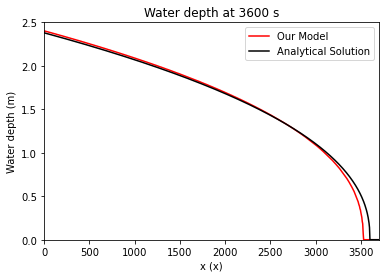

In [10]:
## Code Block 11

data = np.loadtxt('output1_node_surface_water__depth.txt')
nodesToSample = np.arange(rmg.number_of_node_columns+1,2*rmg.number_of_node_columns)
x = np.arange(0,(rmg.number_of_node_columns-1)*rmg.dx,rmg.dx)

hSample = data[-1,nodesToSample]

hAnalytical = np.zeros_like(x)+h_init
hAnalytical[np.where(x<u*tmax)] =(-7/3 * (n**2 * u**2 * (x[np.where(x<u*tmax)]-u*tmax)))**(3/7)

plt.figure(1)
plt.plot(x, hSample, color='red', label='Our Model')
plt.plot(x, hAnalytical, color='black', label='Analytical Solution')
plt.legend()
plt.ylabel('Water depth (m)')
plt.xlabel('x (x)')
plt.ylim(0,2.5)
plt.xlim(0,3700)
plt.title('Water depth at 3600 s')


I imaging there will be some text at the end. Maybe some references or further reading. Maybe some links to the other notebooks. IDK. Will revisit after edits are done.